## $S_{corr} > 3.5 \sigma$

Como va la franja de reals y bogus?

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sqlalchemy import create_engine
import pandas as pd

In [3]:
sns.set_context(font_scale=16)
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['text.usetex'] = True

In [4]:
engine = create_engine('sqlite:///../RBpipeline/newrbogus22-dev.db')

In [5]:
simulated = pd.read_sql_query("""SELECT * FROM Simulated""", engine)

In [6]:
dt_scr = pd.merge(pd.read_sql_table('SCorrDetected', engine),
                  pd.read_sql_query("""SELECT 
                                        SCorrDetected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM SCorrDetected
                                        LEFT JOIN SCorrReals
                                            ON SCorrDetected.id==SCorrReals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==SCorrReals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [7]:
dt_scr.describe()

,id,X_IMAGE,Y_IMAGE,SIGNIFICANCE,image_id,sim_mag,sim_id
count,40297.000000,40297.000000,40297.000000,40297.000000,40297.000000,14094.000000,14094.000000
mean,20149.000000,514.259630,508.935888,29.761659,251.521974,21.342691,19550.163687
std,11632.886235,296.430079,297.947634,119.213881,143.780955,1.404319,11124.882770
min,1.000000,0.000000,0.000000,-170.846727,1.000000,13.664131,2.000000
25%,10075.000000,259.410100,249.140343,3.748996,126.000000,20.618834,10109.500000
50%,20149.000000,515.795043,507.000000,5.810919,253.000000,21.594198,19394.500000
75%,30223.000000,770.689369,767.603501,15.635205,376.000000,22.353458,29342.750000
max,40297.000000,1023.000000,1023.000000,2482.045036,500.000000,25.461951,38510.000000


In [8]:
reals = dt_scr[dt_scr.IS_REAL==True]
bogus = dt_scr[dt_scr.IS_REAL==False]

In [9]:
reals.describe()

,id,X_IMAGE,Y_IMAGE,SIGNIFICANCE,image_id,sim_mag,sim_id
count,14094.000000,14094.000000,14094.000000,14094.000000,14094.000000,14094.000000,14094.000000
mean,20377.041294,512.808824,510.587196,55.827538,254.272031,21.342691,19550.163687
std,11689.171707,290.128259,291.995042,176.860231,144.434541,1.404319,11124.882770
min,4.000000,8.557303,8.485915,3.149219,1.000000,13.664131,2.000000
25%,10406.250000,261.551690,257.600645,6.737161,131.000000,20.618834,10109.500000
50%,20161.500000,512.658899,508.721986,13.488556,253.000000,21.594198,19394.500000
75%,30680.750000,764.039010,766.405085,33.222329,381.000000,22.353458,29342.750000
max,40296.000000,1013.510518,1013.078278,2482.045036,500.000000,25.461951,38510.000000


In [10]:
bogus.describe()

,id,X_IMAGE,Y_IMAGE,SIGNIFICANCE,image_id,sim_mag,sim_id
count,26203.000000,26203.000000,26203.000000,26203.000000,26203.000000,0.0,0.0
mean,20026.341755,515.039986,508.047687,15.741413,250.042781,NaN,NaN
std,11600.868256,299.767478,301.102509,66.861671,143.409126,NaN,NaN
min,1.000000,0.000000,0.000000,-170.846727,1.000000,NaN,NaN
25%,9832.500000,257.501657,244.913043,3.609919,124.000000,NaN,NaN
50%,20142.000000,517.012547,506.366470,4.047633,253.000000,NaN,NaN
75%,29962.500000,774.090129,768.000000,8.360504,372.000000,NaN,NaN
max,40297.000000,1023.000000,1023.000000,2365.103129,500.000000,NaN,NaN


In [11]:
print sum(reals.SIGNIFICANCE<=0.)
print sum(bogus.SIGNIFICANCE<=0.)

0
53


In [13]:
sns.reset_orig()

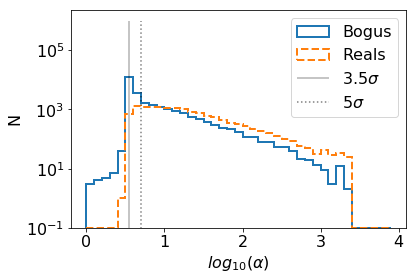

In [17]:
plt.figure(figsize=(6,4))
bins=np.arange(0, 4, .1)

plt.hist(np.log10(bogus.SIGNIFICANCE[bogus.SIGNIFICANCE>0.]), 
         log=True, alpha=1, label='Bogus', bins=bins, histtype='step', lw=2,
         linestyle='-') #, cumulative=True, normed=True)

plt.hist(np.log10(reals.SIGNIFICANCE[reals.SIGNIFICANCE>0.]), 
         log=True, alpha=1, label='Reals', bins=bins, histtype='step', lw=2,
         linestyle='--') #, cumulative=True, normed=True)

plt.vlines(x=np.log10(3.5), ymax=10e5, ymin=0., label=r'$3.5\sigma$', alpha=0.3)
plt.vlines(x=np.log10(5), linestyle=':', ymax=10e5, ymin=0., label=r'$5\sigma$', alpha=0.5)

plt.xlabel(r'$log_{10}(\alpha)$', fontsize=16)
plt.ylabel('N', fontsize=16)

plt.tick_params(labelsize=16)
plt.legend(loc='best', fontsize=16)
plt.savefig('significances.svg', dpi=720)

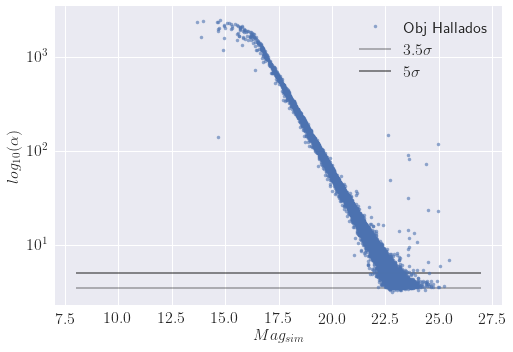

In [13]:
plt.semilogy(reals.sim_mag, reals.SIGNIFICANCE, '.', alpha=0.6,label=r'Obj Hallados')
plt.ylabel(r'$log_{10}(\alpha)$', fontsize=16)
plt.hlines(y=3.5, xmax=27, xmin=8., label=r'$3.5\sigma$', alpha=0.3)
plt.hlines(y=5, xmax=27, xmin=8., label=r'$5\sigma$', alpha=0.5)
plt.tick_params(labelsize=16)
plt.xlabel('$Mag_{sim}$', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.savefig('mag_vs_significance.png', dpi=420)

In [14]:
sum(reals.SIGNIFICANCE>5.)#/float(sum(reals.SIGNIFICANCE>3.5))

12114

In [15]:
float(sum(reals.SIGNIFICANCE>3.5))/len(reals)

0.9973038172271889

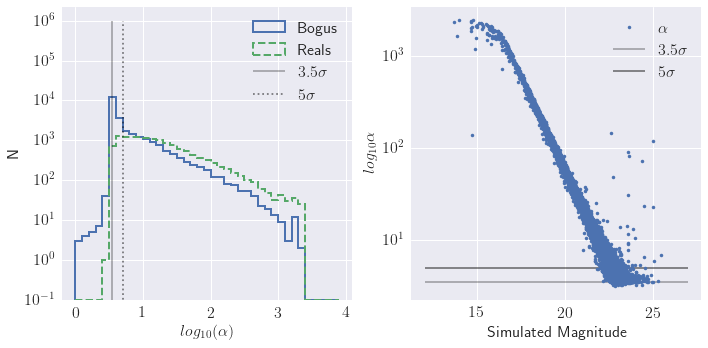

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
bins=np.arange(0, 4, .1)

plt.hist(np.log10(bogus.SIGNIFICANCE[bogus.SIGNIFICANCE>0.]), 
         log=True, alpha=1, label='Bogus', bins=bins, histtype='step', lw=2,
         linestyle='-') #, cumulative=True, normed=True)

plt.hist(np.log10(reals.SIGNIFICANCE[reals.SIGNIFICANCE>0.]), 
         log=True, alpha=1, label='Reals', bins=bins, histtype='step', lw=2,
         linestyle='--') #, cumulative=True, normed=True)

plt.vlines(x=np.log10(3.5), ymax=10e5, ymin=0., label=r'$3.5\sigma$', alpha=0.3)
plt.vlines(x=np.log10(5), linestyle=':', ymax=10e5, ymin=0., label=r'$5\sigma$', alpha=0.5)

plt.xlabel(r'$log_{10}(\alpha)$', fontsize=16)
plt.ylabel('N', fontsize=16)

plt.tick_params(labelsize=16)
plt.legend(loc='best', fontsize=16)

plt.subplot(122)
plt.semilogy(reals.sim_mag, reals.SIGNIFICANCE, '.', label=r'$\alpha$')
plt.ylabel(r'$log_{10}\alpha$', fontsize=16)
plt.hlines(y=3.5, xmax=27, xmin=12., label=r'$3.5\sigma$', alpha=0.3)
plt.hlines(y=5, xmax=27, xmin=12., label=r'$5\sigma$', alpha=0.5)
plt.tick_params(labelsize=16)
plt.xlabel('Simulated Magnitude', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.savefig('significance_magnitudes.png', dpi=420)

In [17]:
def TruePositives(dt, thresh, tot_sim):
    detections = dt[dt.SIGNIFICANCE>thresh]
    return np.sum(detections.IS_REAL)/float(tot_sim)

def FalseNegatives(dt, thresh, tot_sim):
    return 1.-TruePositives(dt, thresh, tot_sim)

def FalsePositives(dt, thresh, tot_sim):
    detections = dt[dt.SIGNIFICANCE>thresh]
    return (len(detections) - np.sum(detections.IS_REAL))/float(tot_sim)

In [18]:
tot_sim = len(simulated)

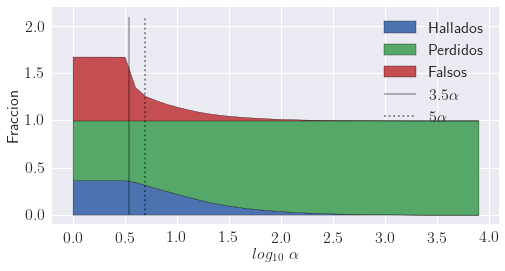

In [19]:
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8, 4))
plt.fill_between(x=np.arange(0., 4., 0.1), y1=0.,
                 y2=[TruePositives(dt_scr, th, tot_sim) for th in 10**np.arange(0., 4., 0.1)],
                 label='Hallados', alpha=1)

plt.fill_between(x=np.arange(0., 4., 0.1), 
                 y1=[TruePositives(dt_scr, th, tot_sim) for th in 10**np.arange(0., 4., 0.1)], 
                 y2=1, label='Perdidos')

plt.fill_between(x=np.arange(0., 4., 0.1), y1=1.,
                 y2=[1.+FalsePositives(dt_scr, th, tot_sim) for th in 10**np.arange(0., 4., 0.1)],
                 label='Falsos')
plt.vlines(x=np.log10(3.5), ymax=2.1, ymin=0., label=r'$3.5\alpha$', alpha=0.3)
plt.vlines(x=np.log10(5), linestyle=':', ymax=2.1, ymin=0., label=r'$5\alpha$', alpha=0.5)

plt.xlabel(r'$log_{10} \ \alpha$', fontsize=16)
plt.ylabel('Fraccion', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tick_params(labelsize=16)
plt.savefig('scorr_thresholds.png', dpi=480)

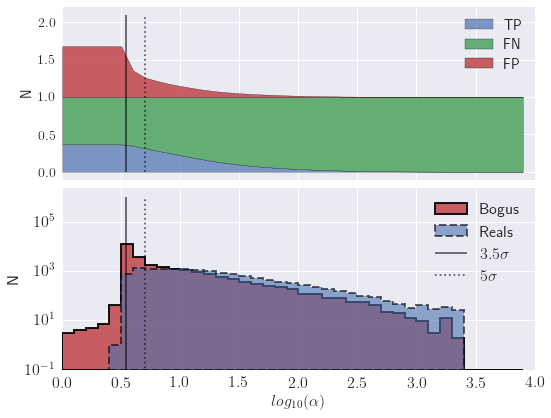

In [20]:
from matplotlib.ticker import NullFormatter

nullfmt = NullFormatter()         # no labels

#positions
left, width = 0.12, 0.82
bottom, height = 0.12, 0.42
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.4]

#figure
plt.figure(1, figsize=(8, 6))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.hist(np.log10(bogus.SIGNIFICANCE[bogus.SIGNIFICANCE>0.]), alpha=0.9,
         log=True, label='Bogus', bins=bins, histtype='stepfilled', lw=2,
         linestyle='-', color=sns.color_palette()[2]) #, cumulative=True, normed=True)

axScatter.hist(np.log10(reals.SIGNIFICANCE[reals.SIGNIFICANCE>0.]), alpha=0.6,
         log=True, label='Reals', bins=bins, histtype='stepfilled', lw=2,
         linestyle='--', color=sns.color_palette()[0]) #, cumulative=True, normed=True)

axScatter.vlines(x=np.log10(3.5), ymax=10e5, ymin=0., label=r'$3.5\sigma$', alpha=0.6)
axScatter.vlines(x=np.log10(5), linestyle=':', ymax=10e5, ymin=0., label=r'$5\sigma$', alpha=0.6)

axScatter.set_xlabel(r'$log_{10}(\alpha)$', fontsize=16)
axScatter.set_ylabel('N', fontsize=16)

axScatter.tick_params(labelsize=16)
axScatter.legend(loc='best', fontsize=16)

# now determine nice limits by hand:
axScatter.set_xlim((0, 4))
# axScatter.set_ylim((-lim, lim))

axHistx.fill_between(x=bins, y1=0.,
                 y2=[TruePositives(dt_scr, th, tot_sim) for th in 10**bins],
                 label='TP', alpha=0.7)

axHistx.fill_between(x=bins, 
                 y1=[TruePositives(dt_scr, th, tot_sim) for th in 10**bins], 
                 y2=1, label='FN', alpha=0.9)

axHistx.fill_between(x=bins, y1=1.,
                 y2=[1.+FalsePositives(dt_scr, th, tot_sim) for th in 10**bins],
                 label='FP', alpha=0.9)
axHistx.vlines(x=np.log10(3.5), ymax=2.1, ymin=0., alpha=0.6)#, label=r'$3.5\sigma$', alpha=0.3)
axHistx.vlines(x=np.log10(5), linestyle=':', ymax=2.1, ymin=0., alpha=0.6)#, label=r'$5\sigma$', alpha=0.5)

axHistx.set_ylabel('N', fontsize=14)
axHistx.legend(loc='best', fontsize=14)
axHistx.tick_params(labelsize=14)

axHistx.tick_params(labelsize=14)
axHistx.set_xlim(axScatter.get_xlim())
axHistx.set_ylabel('N')

plt.savefig('significance_values.pdf', format='pdf', dpi=420)

In [21]:
sns.color_palette()[0]

(0.29803921568627451, 0.44705882352941179, 0.69019607843137254)